## KI430 - NLP


This exercise has three parts:

- Train a Word2Vec model from scratch, using different datasets.
- Load a pre-trained Word2Vec embedding set and evaluate it for its ability to capture concept similarity.
- Train a sentiment analysis classififer built on top of word embeddings.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nlp_labs.utils as U
from pathlib import Path
from expression.collections import Block
import polars as pl
from pprint import pp

In [34]:
ROOT = Path(".")

In [46]:
config = U.load_config(ROOT / ".." / "config.yml").lab_1

In [36]:
resources_dir = ROOT / "resources"
output_dir = ROOT / "out"

### Word2Vec from scratch


> [Gensim](https://radimrehurek.com/gensim/index.html) is designed to process raw, unstructured digital texts (“plain text”) using unsupervised machine learning algorithms. The algorithms in Gensim, such as Word2Vec, FastText, Latent Semantic Indexing (LSI, LSA, LsiModel), Latent Dirichlet Allocation (LDA, LdaModel) etc, automatically discover the semantic structure of documents by examining statistical co-occurrence patterns within a corpus of training documents. These algorithms are unsupervised, which means no human input is necessary – you only need a corpus of plain text documents.


In [5]:
# Train the embedding model using a toy dataset that is part of gensim
from gensim.test.utils import common_texts
from gensim.models.word2vec import Word2Vec

### Instantiate and train model: Word2Vec from gensim.


In [6]:
w2v_model = U.create_word2vec_model(corpus=common_texts, config=config.word2vec)

In [7]:
# dict with vocabulary frequencies
words = w2v_model.wv.key_to_index
words

{'system': 0,
 'graph': 1,
 'trees': 2,
 'user': 3,
 'minors': 4,
 'eps': 5,
 'time': 6,
 'response': 7,
 'survey': 8,
 'computer': 9,
 'interface': 10,
 'human': 11}

In [8]:
# explore embeddings
vector = w2v_model.wv["computer"]  # get numpy vector of a word
f"The vector length of the word is {len(vector)}"

'The vector length of the word is 100'

In [9]:
# Print 14 most similar words. Use `most_similar` function.
# TODO
word = "computer"
similar_words = U.most_similar(word=word, w2v_model=w2v_model, topn=14)
similar_words.ok if similar_words.is_ok() else similar_words.error

[('system', 0.21617139875888824),
 ('survey', 0.04468922317028046),
 ('interface', 0.015203381888568401),
 ('time', 0.0019510635174810886),
 ('trees', -0.03284316882491112),
 ('human', -0.07424270361661911),
 ('response', -0.09317591041326523),
 ('graph', -0.09575342386960983),
 ('eps', -0.10513808578252792),
 ('user', -0.16911619901657104),
 ('minors', -0.17323409020900726)]

#### Tokenization

A typical step in any NLP task is to split raw data into words. Raw data here means all the punctuation, smileys etc. attached, which we may or may not want to have. So a simple `str.split()` is not working. Let's look at `nltk` to help with tokenization.


### what is this doing?

The `WordPunctTokenizer` is a tokenizer that splits a text into words using punctuation (e.g., commas, periods, etc.) as separators.
It treats any sequence of non-alphanumeric characters as a single token.


In [5]:
from nltk.tokenize import WordPunctTokenizer
from expression.collections import Block

tokenizer = WordPunctTokenizer()

In [11]:
# TODO: lowercase all words and extract tokens with tokenizer.
# the result should be a list of lists of tokens, for each line in the original data

# TODO: YOUR CODE
file_paths = [resources_dir / "quora.txt"]


def processor(line, **kwargs):
    result = U.tokenize_line(line, tokenizer)
    U.file_writer(result, kwargs["output_path"])
    return result

In [14]:
quoras_tokenized = Block(
    U.process_file(file_paths[0], output_dir=output_dir, processor=processor)
).map(lambda line: Block(line.split(" ")[:-2]).map(str.lower))

In [15]:
# Repeat the previous steps and look into the embeddings.
# TODO: YOUR CODE
quoras_w2v = U.create_word2vec_model(quoras_tokenized, config.word2vec)

In [16]:
word = "game"
similar_words = U.most_similar(word=word, w2v_model=quoras_w2v, topn=14)
similar_words.ok if similar_words.is_ok() else similar_words.error

[('games', 0.7699108719825745),
 ('player', 0.6879673004150391),
 ('video', 0.659733235836029),
 ('team', 0.6490747332572937),
 ('thrones', 0.636497974395752),
 ('chess', 0.633880615234375),
 ('ps4', 0.6063315868377686),
 ('sport', 0.6062596440315247),
 ('minecraft', 0.6020464301109314),
 ('movie', 0.5978693962097168),
 ('fantasy', 0.5958715677261353),
 ('series', 0.5950285196304321),
 ('tv', 0.5910345911979675),
 ('star', 0.5859441757202148)]

### Word embedding similarities


In [12]:
from gensim.models import KeyedVectors

In [13]:
# Load the pre-trained version of Word2Vec that has been trained on a part of the Google News dataset (about 100 billion words). Use the embeddings with 300 dimensions, which cover about 3 million words and phrases.

# TODO: YOUR CODE HERE
w2v_vectors_path = resources_dir / "GoogleNews-vectors-negative300.bin.gz"

# Load the model
# This can take some time due to the size of the model (around 3.5GB)
w2v_vectors = KeyedVectors.load_word2vec_format(w2v_vectors_path, binary=True)

In [14]:
from sklearn.manifold import TSNE

# visualization utility function. NO NEED TO CHANGE ANYTHING HERE
sns.set_style("whitegrid")
sns.set_theme(rc={"figure.figsize": (19.7, 8.27)})


def tsne_scatterplot(model, search_word, topn):
    labels = [search_word]
    tokens = [model[search_word]]
    similar = [1]
    close_words = model.similar_by_word(search_word, topn=topn)
    for word in close_words:
        tokens.append(model[word[0]])
        labels.append(word[0])
        similar.append(word[1])

    tsne_model = TSNE(n_components=2, perplexity=topn, init="pca")
    coordinates = tsne_model.fit_transform(np.array(tokens))
    df = pd.DataFrame(
        {
            "x": [x for x in coordinates[:, 0]],
            "y": [y for y in coordinates[:, 1]],
            "words": labels,
            "similarity": similar,
        }
    )
    fig, ax = plt.subplots()
    plot = ax.scatter(df.x, df.y, c=df.similarity, cmap="Reds")
    for i in range(len(df)):
        ax.annotate(
            "  {} ({:.2f})".format(df.words[i].title(), df.similarity[i]),
            (df.x[i], df.y[i]),
        )

    plt.colorbar(mappable=plot, ax=ax)
    plt.title("t-SNE visualization for {}".format(search_word))
    plt.show()

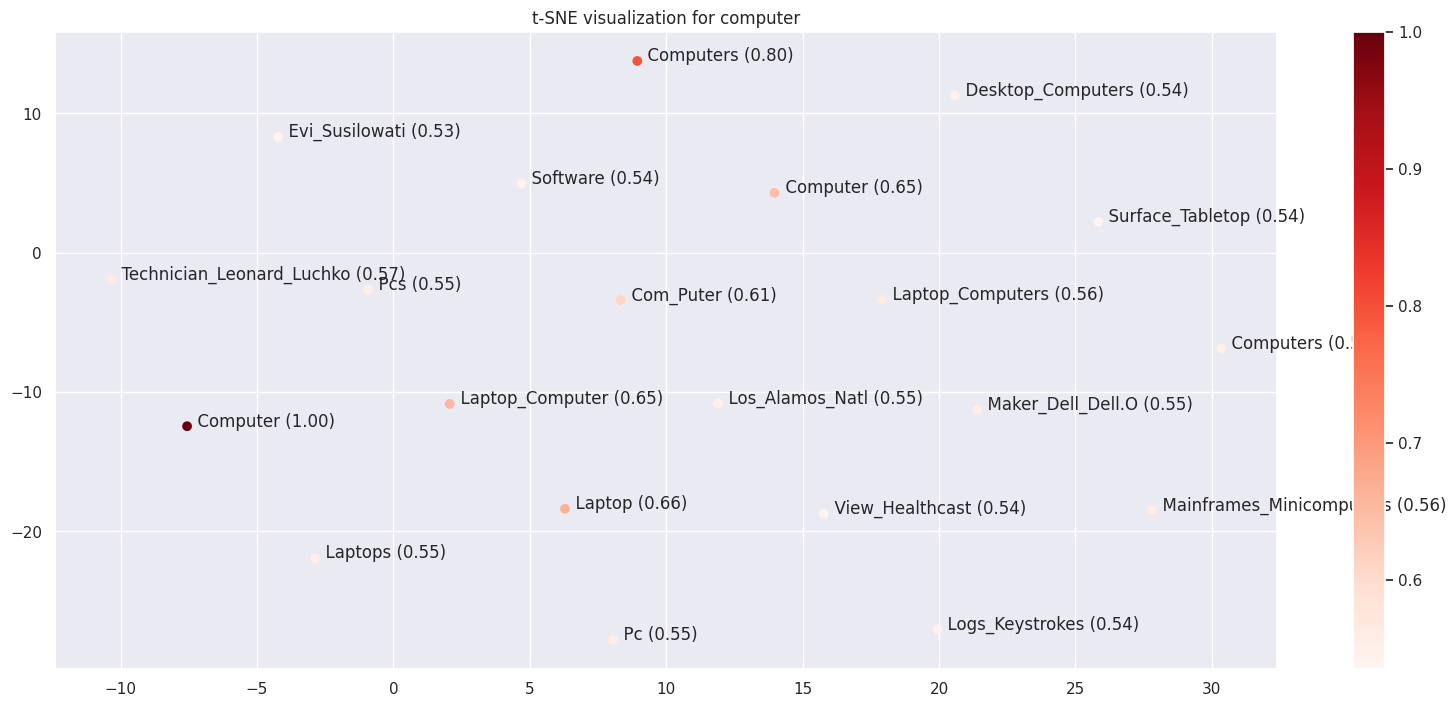

In [15]:
# visualize the most similar words for a given word.
tsne_scatterplot(w2v_vectors, "computer", 20)

### Word analogies

A huge inspiration for utilizing numerical representations for words is the ability to solve word analogies using simple arithmetic on the numerical representations.


In [16]:
# Use the triplets King, Man, Woman and France, Paris, Athens together with `.most_similar_words` to find meaningful analogies. What can you do with the words Doctor, Man, Woman, Nurse?
# TODO: YOUR CODE
words_1 = ["King", "Woman", "Man", "France", "Paris", "Athens"]
words_2 = ["Doctor", "Man", "Woman", "Nurse"]

analogies_1 = (
    Block(U.find_analogies(w2v_vectors, words_1))
    .filter(lambda result: result.is_ok())
    .map(lambda r: r.ok)
    .map(lambda words: f"{words[-1]} to {words[0]} is like {words[1]} to {words[2]}")
)
analogies_2 = (
    Block(U.find_analogies(w2v_vectors, words_2))
    .filter(lambda result: result.is_ok())
    .map(lambda r: r.ok)
    .map(lambda words: f"{words[-1]} to {words[0]} is like {words[1]} to {words[2]}")
)

In [17]:
for analogy in analogies_1:
    pp(analogy)

'Woman to Man is like King to king'
'Woman to France is like King to Spain'
'Woman to Paris is like King to Prince'
'Woman to Athens is like King to Athen'
'Man to Woman is like King to Queen'
'Man to France is like King to Franche_Comte'
'Man to Paris is like King to Hopital_Europeen_Georges_Pompidou'
'Man to Athens is like King to Organising_Committee_ATHOC'
'France to Woman is like King to Man'
'France to Man is like King to Boy'
'France to Paris is like King to Jackson'
'France to Athens is like King to Bainbridge'
'Paris to Woman is like King to Man'
'Paris to Man is like King to Monkey'
'Paris to France is like King to king'
'Paris to Athens is like King to Bainbridge'
'Athens to Woman is like King to Man'
'Athens to Man is like King to Boy'
'Athens to France is like King to Louis_XVIII'
'Athens to Paris is like King to Louis_XVIII'
'King to Man is like Woman to Couple'
'King to France is like Woman to Brive_la'
'King to Paris is like Woman to By_PETA_Protester'
'King to Athens i

In [18]:
for analogy in analogies_2:
    pp(analogy)

'Man to Woman is like Doctor to Surgeon'
'Man to Nurse is like Doctor to Nurse_Practitioner'
'Woman to Man is like Doctor to Doc'
'Woman to Nurse is like Doctor to Clinical_Pharmacist'
'Nurse to Man is like Doctor to Boy'
'Nurse to Woman is like Doctor to Man'
'Doctor to Woman is like Man to Couple'
'Doctor to Nurse is like Man to Woman'
'Woman to Doctor is like Man to Doc'
'Woman to Nurse is like Man to Doctor'
'Nurse to Doctor is like Man to Boy'
'Nurse to Woman is like Man to Couple'
'Doctor to Man is like Woman to Couple'
'Doctor to Nurse is like Woman to Couple'
'Man to Doctor is like Woman to Surgeon'
'Man to Nurse is like Woman to Nursing'
'Nurse to Doctor is like Woman to Man'
'Nurse to Man is like Woman to Couple'
'Doctor to Man is like Nurse to Woman'
'Doctor to Woman is like Nurse to Couple'
'Man to Doctor is like Nurse to Nurse_Practitioner'
'Man to Woman is like Nurse to Nursing'
'Woman to Doctor is like Nurse to Clinical_Pharmacist'
'Woman to Man is like Nurse to Doctor'


### Sentiment Analysis of movie reviews

Build a sentiment classification model using the IMDB review dataset. Download the dataset from [here](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/download?datasetVersionNumber=1). More dataset info is [here](http://ai.stanford.edu/~amaas/data/sentiment/). The goal of this section is to predict if a review is positive or negative using a classification algorithm. You are free to choose your classifier, this document suggests (and gives a few lines of code) for a pytorch based neural network.


#### Dataset exploration


In [6]:
imdb_dataset_path = resources_dir / "IMDB Dataset.csv"
movie_reviews = pl.read_csv(imdb_dataset_path)

'Number of movie reviews: 50000'
('Number of classes: 2 with values: shape: (2, 1)\n'
 '┌───────────┐\n'
 '│ sentiment │\n'
 '│ ---       │\n'
 '│ str       │\n'
 '╞═══════════╡\n'
 '│ negative  │\n'
 '│ positive  │\n'
 '└───────────┘')
'# of positive samples: 25000'
'# of negative samples: 25000'


<Axes: xlabel='sentiment', ylabel='count'>

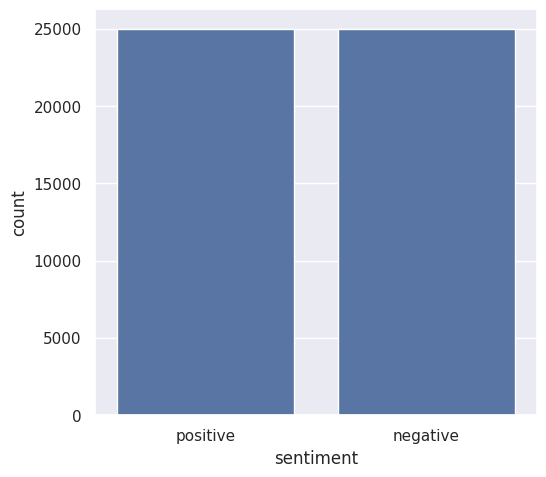

In [7]:
# read dataset
pp(f"Number of movie reviews: {movie_reviews.height}")
classes = movie_reviews.select("sentiment").unique()
pp(f"Number of classes: {classes.height} with values: {classes}")

# class distribution
positive = movie_reviews.filter(pl.col("sentiment") == pl.lit("positive"))
negative = movie_reviews.filter(pl.col("sentiment") == pl.lit("negative"))

pp("# of positive samples: {}".format(positive.height))
pp("# of negative samples: {}".format(negative.height))

sns.set_theme(rc={"figure.figsize": (5.7, 5.27)})
sns.countplot(x=movie_reviews["sentiment"])

#### Data preprocessing

In order to build a classifier, leverage a pretrained word embedding model (see above). In order to handle sentences of variable lengths, we aggregate word embeddings of a sentence using either averaging oder max-pooling.

More specfically, do the following:

- Change the classes from str (negative, positive) to binary (0, 1), a new column in the data frame.
- Get word embeddings and calculate the sentence vectors with both max and avg pooling. In order to tokenize the data, either follow your previous approach or look into gensim.utils.tokenize.
- Create a pytorch.Dataset instance of the IMDB data.


In [8]:
movie_reviews_tokenized = movie_reviews.with_columns(
    pl.col("review").map_elements(lambda r: tokenizer.tokenize(r)).alias("review"),
    pl.when(pl.col("sentiment") == pl.lit("positive"))
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias("sentiment"),
)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


In [9]:
w2v_imdb = U.create_word2vec_model(
    movie_reviews_tokenized.select("review").to_series().to_list(), config.word2vec
)

In [10]:
movie_reviews_vectorized = movie_reviews_tokenized.with_columns(
    pl.col("review")
    .map_elements(lambda r: U.average_pooling(r, w2v_imdb))
    .alias("review")
)

/tmp/ipykernel_111833/2714366097.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  movie_reviews_vectorized = movie_reviews_tokenized.with_columns(


ds
Create a pytorch Dataset class with the input data. Instantiate this class with the input data. See the next cell for a simple example. Also ensure to split the dataset into a train- and test sets. Use e.g. `torch.utils.data.random_split` for this.


In [11]:
from nlp_labs.data import IMDBDataModule, IMDBreviews

In [12]:
imdb_dataset = IMDBreviews(
    movie_reviews_vectorized.select("review").to_series().to_numpy(),
    movie_reviews_vectorized.select("sentiment").to_series().to_numpy(),
)

In [13]:
datamodule = IMDBDataModule(
    dataset=imdb_dataset,
    batch_size=config.word2vec.batch_size,
    test_size=config.word2vec.test_size,
    n_workers=config.word2vec.workers,
)

In [14]:
datamodule.setup()

In [42]:
from pytorch_lightning import Trainer
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from nlp_labs.models.sentiment_model import SentimentAnalysisModel
from pytorch_lightning.loggers import TensorBoardLogger

# Initialize callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=config.word2vec.checkpointdir,
    filename="best-checkpoint",
    save_top_k=1,
    mode="min",
)
lr_monitor = LearningRateMonitor(logging_interval="step")
model_logger = TensorBoardLogger(
    config.word2vec.logger.logdir, name=config.word2vec.logger.name
)
model = SentimentAnalysisModel(
    input_dim=config.word2vec.vector_size, inference_steps=500, lr=config.word2vec.lr
)
model

SentimentAnalysisModel(
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [47]:
trainer = Trainer(
    max_epochs=config.word2vec.epochs,
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=50,
    logger=model_logger,
    accelerator="cpu",
)
torch.set_float32_matmul_precision("high")
trainer

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/w/.cache/pypoetry/virtualenvs/nlp-labs-pyUNGD_i-py3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [48]:
trainer.fit(model, datamodule=datamodule)

/home/w/.cache/pypoetry/virtualenvs/nlp-labs-pyUNGD_i-py3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/w/Lernen/NLP/NLP_Labs/lab_1/checkpoints exists and is not empty.

  | Name    | Type    | Params
------------------------------------
0 | linear  | Linear  | 101   
1 | sigmoid | Sigmoid | 0     
------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [49]:
trainer.test(model, datamodule=datamodule)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.833899974822998
      test_f1_score         0.8424063324928284
        test_loss           0.3757908344268799
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3757908344268799,
  'test_accuracy': 0.833899974822998,
  'test_f1_score': 0.8424063324928284}]